# First experiment
## Basic network, one hidden layer, only hidden activation function are modified


In this experiment we are going to test the robustness of neural networks in a very basic configuration, using Activation Function in the hidden layer as a changing parameter.
The constant characteristics of the networks are:
* Dataset = fashon_mnist
* Loss = cathegorical crossentropy
* Output activation = softmax
* Number of hidden layers = 1
* Early stopping metric =  val_loss with patience 10

After having our models correctly set up, we are going to attack them and measure their robustness according to some metrics (before and after attack):
* Accuracy
* Precision
* Recall
* Max and min confidence
* Confusion matrix
* Most and least robust class


## Imports

In [1]:
from functions import *
# plt.rcParams["figure.figsize"] = (20, 10)
import time
import gc
from PIL import Image
import glob
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Model

### Data Load and Preprocessing

In [2]:
# load data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("Train set: ", train_images.shape)
print("Test set: ", test_images.shape)

# divide data into classes
subsets = []
n_classes = 10
for i in range(n_classes):
    tmp_list = []
    for j in range(test_images.shape[0]):
        c = np.nonzero(test_labels[j])[0][0]
        if c == i:
            tmp_list.append(test_images[j])
    tmp_list = np.array(tmp_list)
    subsets.append(tmp_list)
# now we have subsets which is a 10-elements list containing arrays of same class images

new_test_images = np.zeros((0,28,28))
for i in range(len(subsets)):
    new_test_images = np.concatenate((new_test_images, subsets[i]))
# now we have new_test_images which is test_images sorted by class

new_test_labels = np.zeros((0,n_classes))
for i in range(n_classes):
    tmp = np.zeros((subsets[i].shape[0],n_classes))
    tmp[:,i] = 1
    new_test_labels = np.concatenate((new_test_labels, tmp))
# now we have new_test_labels which is test_labels sorted to fit subsets

Train set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


### Build and Train Models

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    network = models.Sequential()
    network.add(layers.Flatten())
    network.add(layers.Dense(DEEP_NEURONS,activation=function,input_shape=INPUT_SHAPE,kernel_initializer=initializer,))
    network.add(layers.Dense(10, activation=OUT_ACTIVATION))
    network.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    print(f'Network training with ativation function = "{function}"')

    es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)
    path = MODELS_PATH+"/best_" + function + ".h5"
    mc = ModelCheckpoint(filepath=path, monitor="val_loss", mode="min", save_best_only=True)
    cb_list = [es, mc]

    h = network.fit(train_images,train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT,callbacks=cb_list)

    # At this point we have best models saved in "best_models" folder

### Model Metrics Evaluation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    print(f'Evaluate model with hidden activation function "{function}"...')
    name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(name)
    metrics_name = "scores_best_"+function
    m = ModelMetrics(metrics_name, new_test_images, new_test_labels, model.predict(new_test_images))
    m.buil_metrics()
    path = SCORES_PATH+"/"+metrics_name
    save_object(m, path)

## Attack

The attack consists of these steps:
1. select the model
2. take the test set and, for each class, find the most vulnerable pixel and the corresponding value (i.e. x,y,z)
3. modify the entire test set changing the pixel values found in the previous step
4. evaluate all the metrics of the selected model with the modified test set


### Prepare Attack

In [4]:
def objective(trial, m, test, current_class):

    xp = trial.suggest_int("xp", MIN_XP, MAX_XP)
    yp = trial.suggest_int("yp", MIN_YP, MAX_XP)
    value = trial.suggest_uniform("zp", MIN_ZP, MAX_ZP)

    new_test_labels = np.zeros((test.shape[0],10))
    new_test_labels[:,current_class] = 1

    tmp = np.copy(test)
    tmp[:,xp,yp] = value

    # minimize loss

    return m.evaluate(tmp,new_test_labels, verbose=0)[1]

def print_best_callback(study, trial):
    print(f"#Trial: {trial.number}, Best value: {study.best_value}, Best params: {study.best_trial.params}")

### Perform Attack

In [ ]:
start_time = time.time()

for function, initializer in DEEP_ACTIVATION.items(): # 7
    model_name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(model_name)
    new_attacked_test_images = np.zeros((0,28,28))
    for i in CLASS_NAMES: # 10

        if not VERBOSITY:
            optuna.logging.set_verbosity(optuna.logging.WARNING)

        func = lambda trial: objective(trial, model, subsets[i], i)

        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name,direction=DIRECTION, sampler=SAMPLER)
        study.optimize(func, n_trials=N_TRIALS, timeout=TIMEOUT, callbacks=[print_best_callback])


# 2048 = 35742.56469321251 seconds = x hours
print("--- %s seconds ---" % (time.time() - start_time))

### Visualize Attack

#### Data preparation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    accuracy_trend = {0:load_object(SCORES_PATH+"/scores_best_"+function).accuracy}
    for c in range(N_CHECKPOINTS):
        attacked_test_images = np.zeros((0,28,28))
        x = (c+1)*int((N_TRIALS/N_CHECKPOINTS))
        for i in CLASS_NAMES:
            study_name = f"study_{function}_{i}"
            storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
            study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
            df = study.trials_dataframe(attrs=("value", "params"))

            idx = df['value'].head(x).idxmin()

            xp = df['params_xp'][idx]
            yp = df['params_yp'][idx]
            zp = df['params_zp'][idx]

            sub_attacked_test_images = np.copy(subsets[i])
            sub_attacked_test_images[:,xp,yp] = zp
            attacked_test_images = np.concatenate((attacked_test_images, sub_attacked_test_images))
        # here we have attacked_test_images correctly built
        metrics_name = "acc_trend_"+function
        name = MODELS_PATH+"/best_" + function + ".h5"
        model = load_model(name)
        m = ModelMetrics(metrics_name, attacked_test_images, new_test_labels, model.predict(attacked_test_images))
        m.buil_metrics()
        if c==(N_CHECKPOINTS-1):
            path = SCORES_PATH+"/scores_best_"+function+"_best_attack"
            save_object(m, path)
        accuracy_trend[x] = m.accuracy
        del m
        gc.collect()
    path = SCORES_PATH+"/"+metrics_name
    save_object(accuracy_trend, path)
    # here we have saved attacked models metrics for each checkpoint for one function

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    for i in CLASS_NAMES:
        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
        fig = optuna.visualization.matplotlib.plot_contour(study, params=['xp', 'yp'], target_name='')
        fig.invert_yaxis()
        fig.set_title(f"Function={function}, Class={i}")
        path = f"{ATTACK_SURFACE_FIG_PATH}/attack_surface_{function}_{i}.png"
        plt.savefig(path)

In [8]:
from numpy import asarray
columns = len(DEEP_ACTIVATION)
rows = len(CLASS_NAMES)

image_list = []
for filename in glob.glob(ATTACK_SURFACE_FIG_PATH+"/*.png"): #assuming gif
    im=Image.open(filename)
    im = asarray(im)
    image_list.append(im)

#### Table "functions vs classes" of attack surface

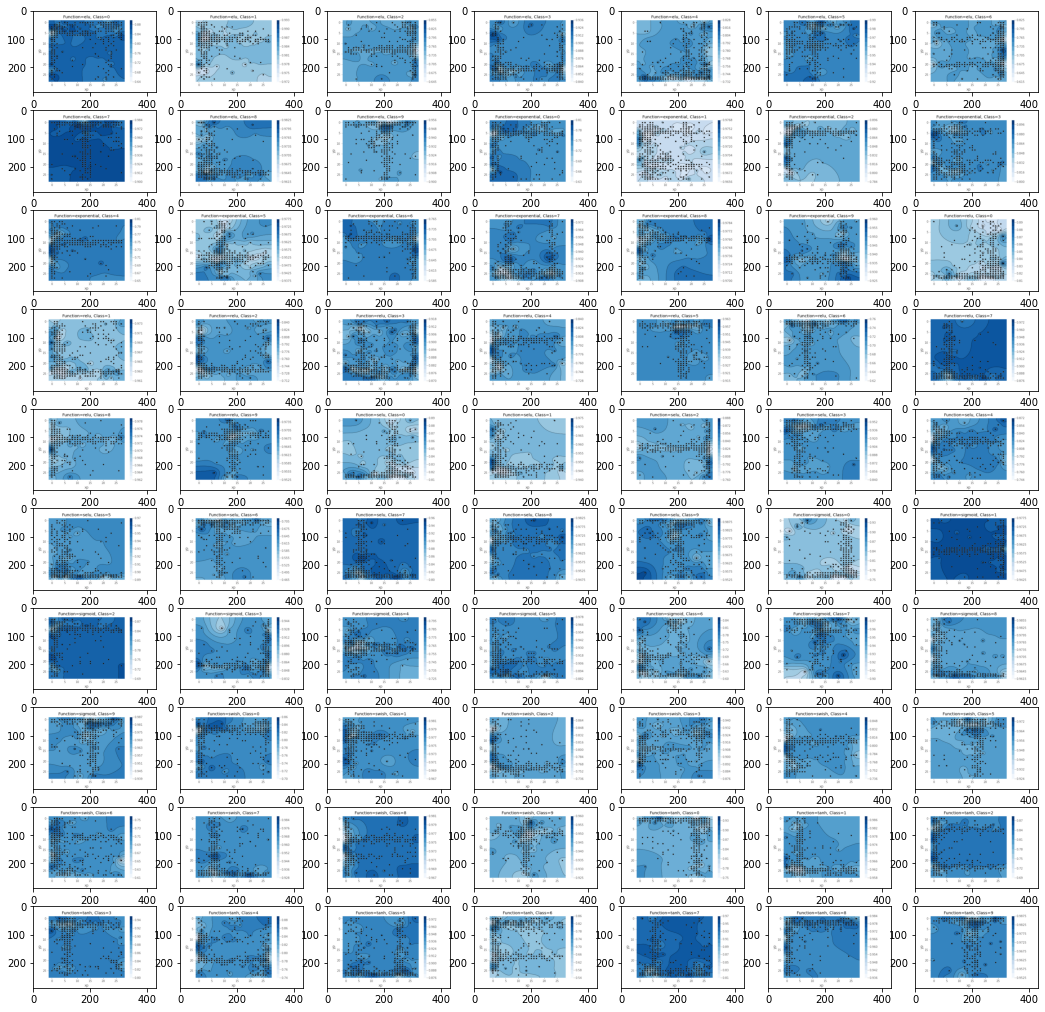

In [9]:
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(18,18))
img_count = 0
for i in range(rows):
    for j in range(columns):
        if img_count < len(image_list):
            axes[i, j].imshow(image_list[img_count])
            img_count+=1

#### Accuracy trend for each function

base-model accuracy:0.8908
2048-optuna-iterations-model accuracy:0.8201
difference:0.0707


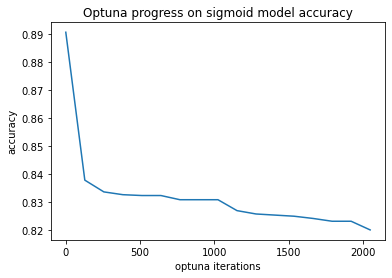

base-model accuracy:0.8912
2048-optuna-iterations-model accuracy:0.8049
difference:0.0863


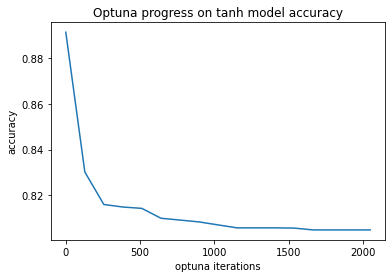

base-model accuracy:0.8856
2048-optuna-iterations-model accuracy:0.8423
difference:0.0433


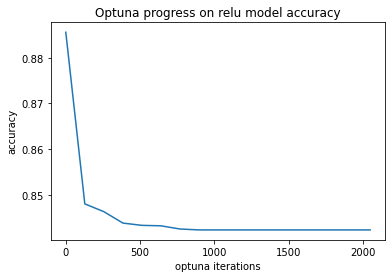

base-model accuracy:0.8808
2048-optuna-iterations-model accuracy:0.8177
difference:0.0631


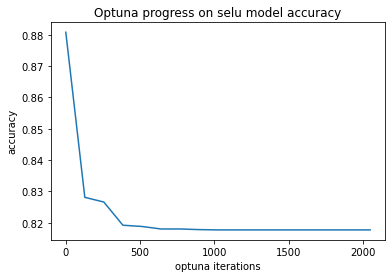

base-model accuracy:0.8869
2048-optuna-iterations-model accuracy:0.8151
difference:0.0718


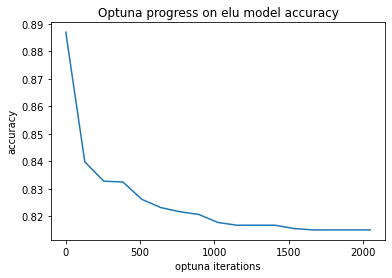

base-model accuracy:0.8728
2048-optuna-iterations-model accuracy:0.8169
difference:0.0559


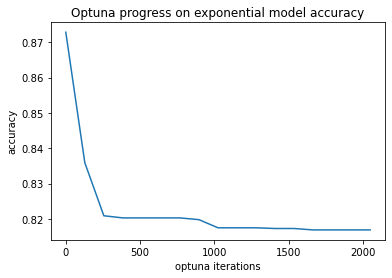

base-model accuracy:0.8868
2048-optuna-iterations-model accuracy:0.8372
difference:0.0496


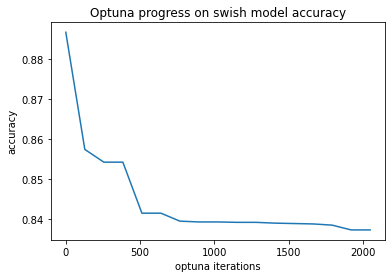

In [5]:
for function, initializer in DEEP_ACTIVATION.items():
    d = load_object(f"./scores/acc_trend_{function}")
    keys = np.fromiter(d.keys(), dtype=int)
    vals = np.fromiter(d.values(), dtype=float)
    print(f"base-model accuracy:{vals[0]}\n2048-optuna-iterations-model accuracy:{vals[-1]}\ndifference:%.4f" % (vals[0]-vals[-1]))

    plt.plot(keys, vals, label = "line 1")
    plt.title(f'Optuna progress on {function} model accuracy')
    plt.xlabel('optuna iterations')
    plt.ylabel('accuracy')
    plt.show()

#### Best attack for each function

index=7237 value=0.9561007022857666


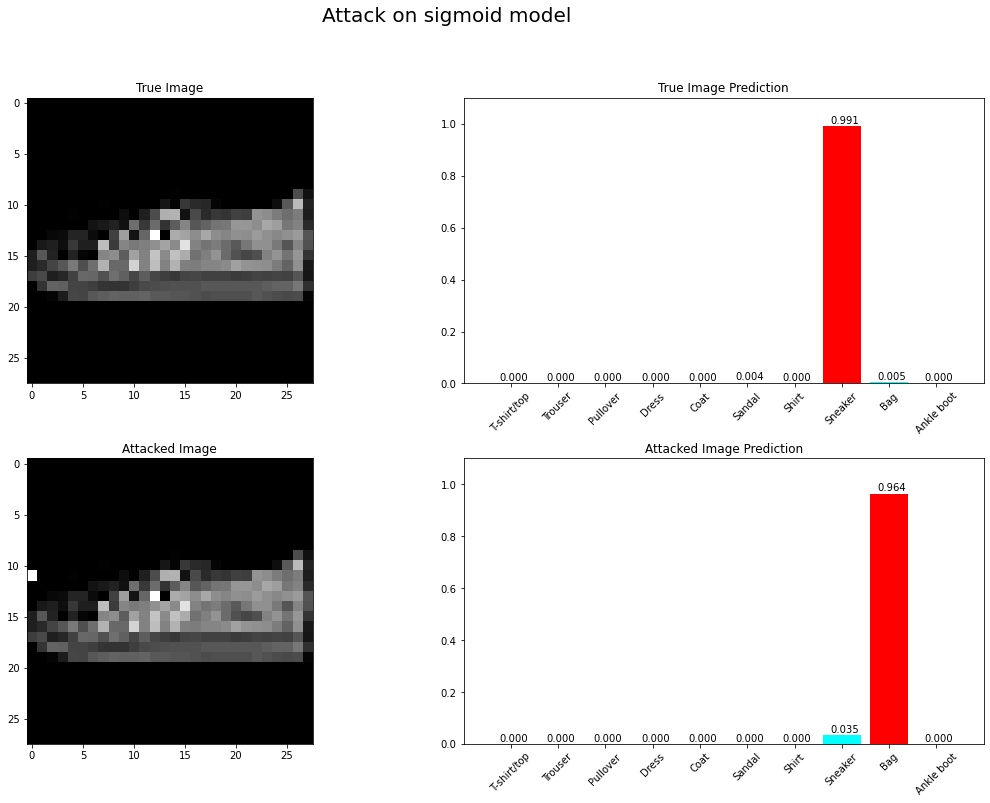

index=5169 value=0.967735230922699


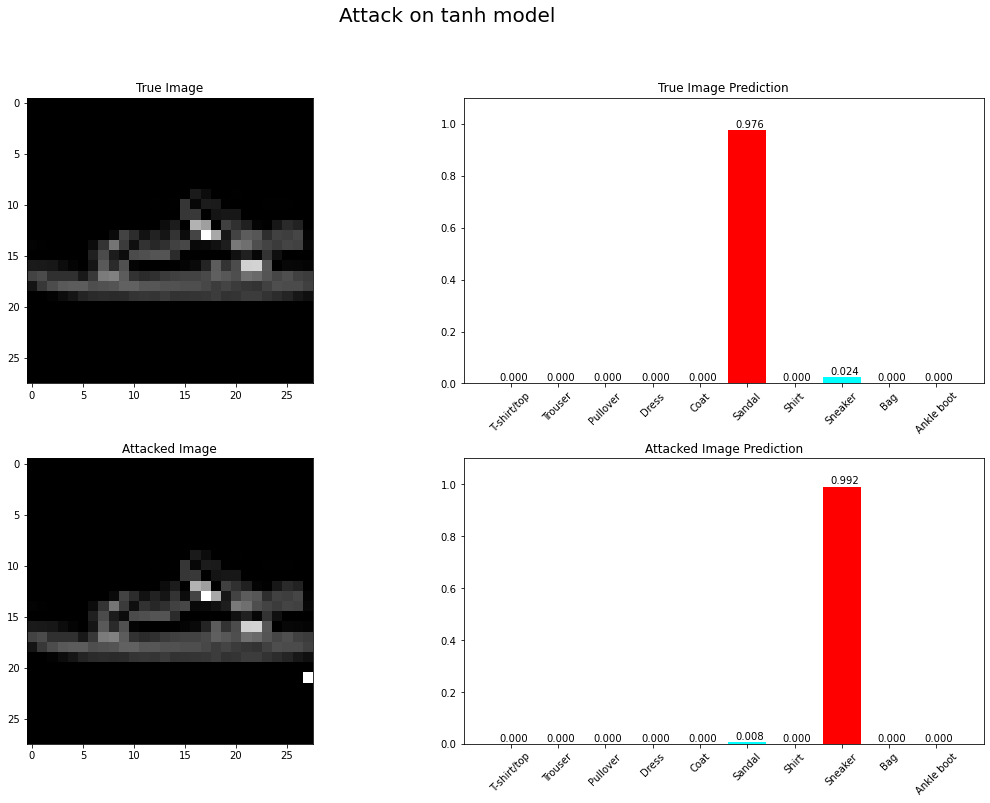

index=5539 value=0.7129015922546387


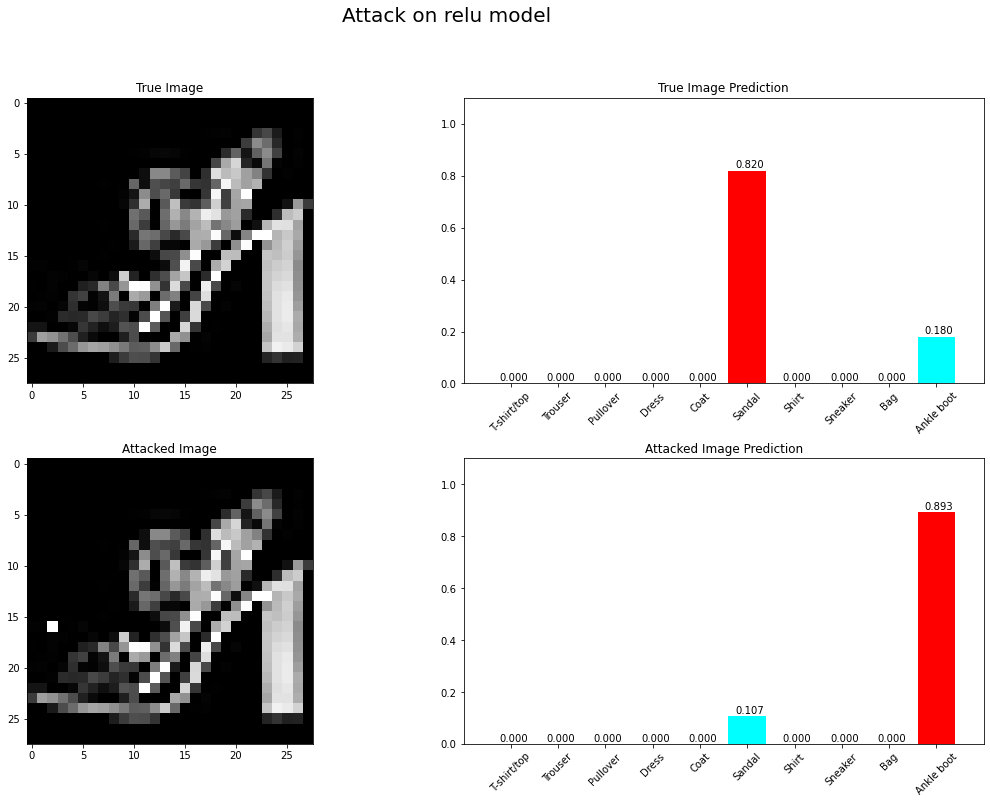

index=6159 value=0.7410939931869507


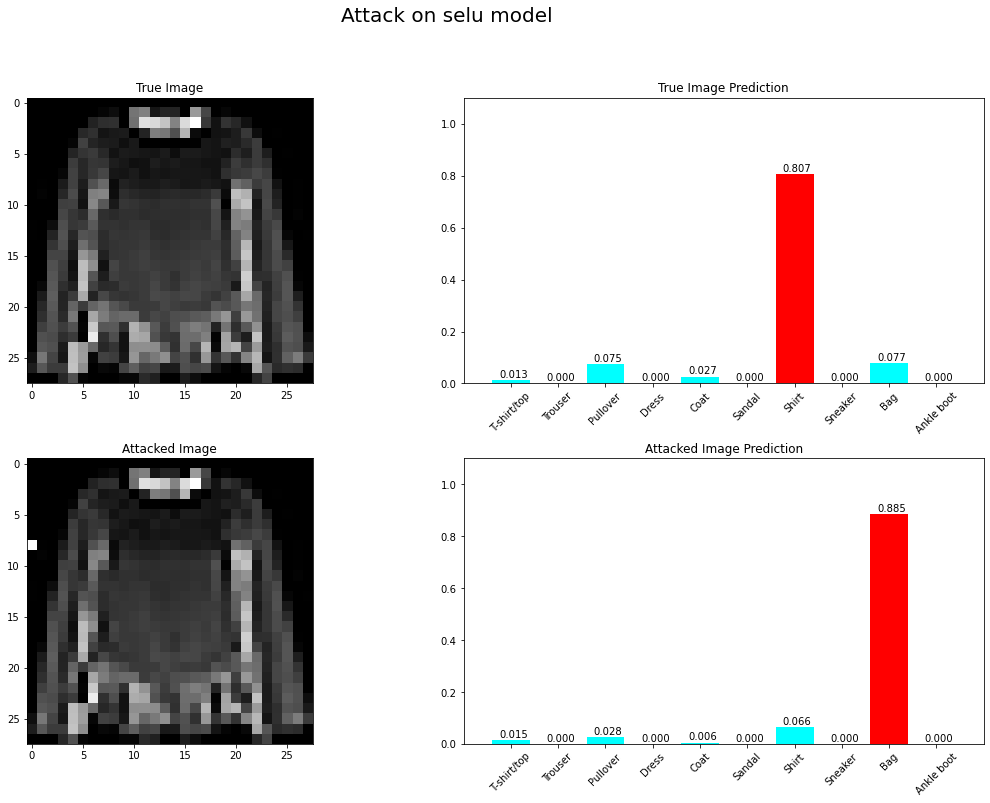

index=5169 value=0.7513112425804138


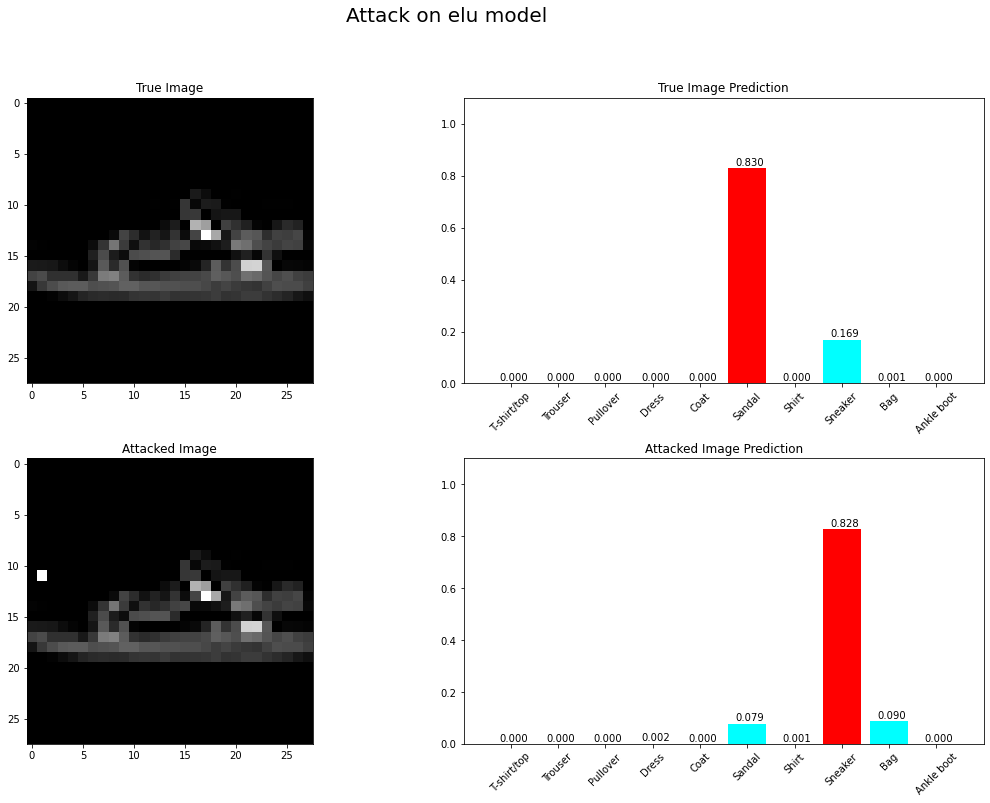

index=3125 value=0.6069347858428955


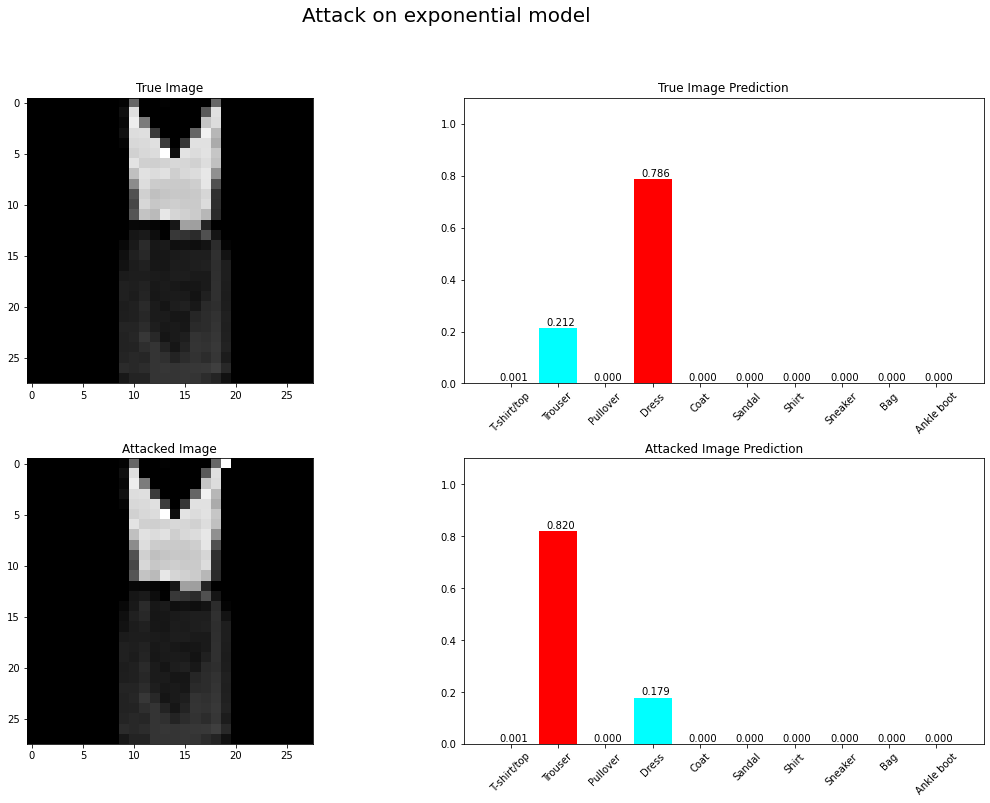

index=6871 value=0.6275617480278015


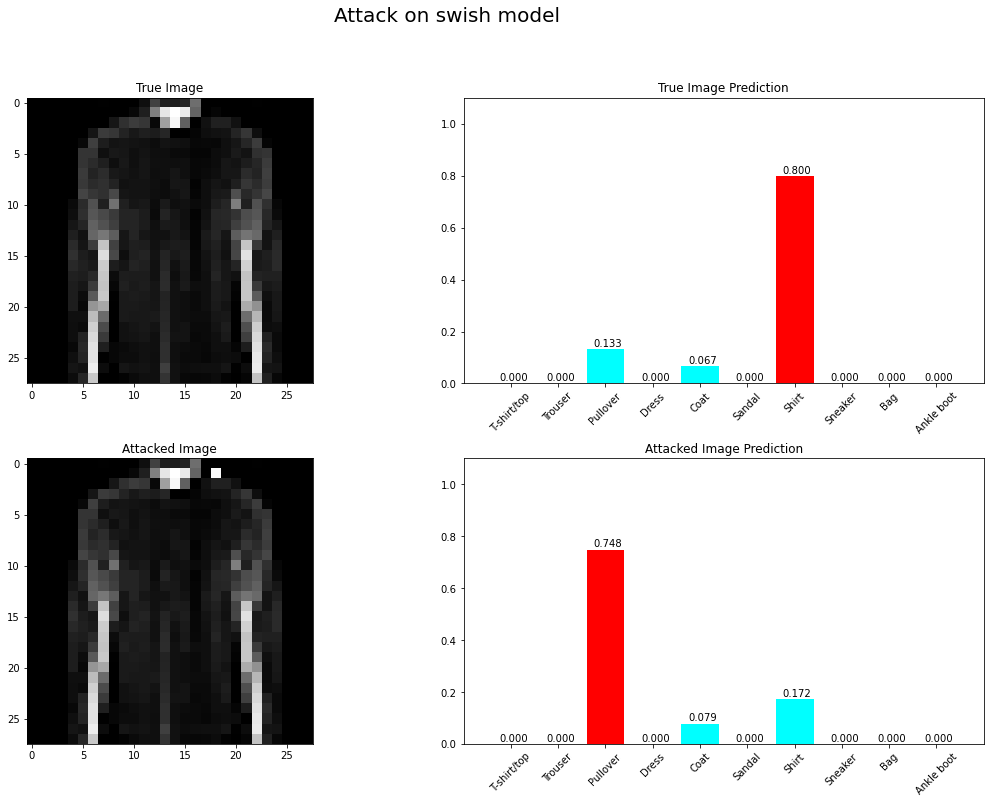

In [6]:
for function, initializer in DEEP_ACTIVATION.items():
    m1 = load_object(SCORES_PATH+"/scores_best_"+function)
    m2 = load_object(SCORES_PATH+"/scores_best_"+function+"_best_attack")
    m = load_model(MODELS_PATH+"/best_"+function+".h5")
    best_attack = 0
    maximum = 0
    for i in range (len(m1.y_true)): # per ogni immagine
        j = np.nonzero(m1.y_true[i])[0][0] # predizione vera
        k = abs(m1.y_pred[i][j] - m2.y_pred[i][j])
        if k >= maximum:
            maximum = k
            best_attack = i

    print(f"index={best_attack} value={maximum}")
    plot_attack(m1.x_test[best_attack], m2.x_test[best_attack], m, function)